# Final Project Submission!
You can find a link to my video here: https://drive.google.com/drive/folders/1bxVw0pMe232iWy6hRtMCOFjt7vLWa_en?usp=sharing

# Installs

In [1]:
!pip install datasets
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 451 kB 29.1 MB/s 
     |████████████████████████████████| 132 kB 78.5 MB/s 
     |████████████████████████████████| 182 kB 56.4 MB/s 
     |████████████████████████████████| 212 kB 71.1 MB/s 
     |████████████████████████████████| 127 kB 64.6 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 9.2 MB/s 
     |████████████████████████████████| 7.6 MB 69.5 MB/s 


# Imports

In [2]:
from transformers import DistilBertTokenizerFast, DistilBertForQuestionAnswering
from datasets import load_dataset

import torch
import numpy as np
import random

# we set up some seeds so that we can reproduce results
seed = 123
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

# Load Model

In [3]:
# Loads model and tokenizer
def load_model():
  # pre-trained 
  config = 'distilbert-base-uncased'

  # model
  untrained_model = DistilBertForQuestionAnswering.from_pretrained(config) 

  # tokenizer
  tokenizer = DistilBertTokenizerFast.from_pretrained(config) 
  return untrained_model, tokenizer

# Load Data

In [4]:
# Get dataset using dataset package, train/validation split
def load_data():
  dataset = load_dataset('cjlovering/natural-questions-short')
  train = dataset['train']
  validation = dataset['validation']
  # 13,933 train, 871 validation
  return train, validation

# Torch Dataset Class

In [5]:
# Helper to get qustions from dataset
def get_questions(dataset):
  questions = []
  # each element is a 1-element list
  for element in dataset['questions']:
    question = element[0]['input_text']
    questions.append(question)

  return questions


# Helper to get_labels
# find start/end index of context
def get_context_inds(sequence_ids):

  # sequence_ids[ind] = 1 for context
  #                   = 0/None else
  ind = 0
  while sequence_ids[ind] != 1:
      ind += 1
  context_start = ind

  while sequence_ids[ind] == 1:
      ind += 1
  context_end = ind - 1

  return context_start, context_end


# Helper to get labels
# Labels = start position, end position
def get_labels(answer, offset_mapping, sequence_ids):

  # Step 1: find context indices (token inds)
  context_start, context_end = get_context_inds(sequence_ids) 

  # Step 2: get answer indices (character inds)
  ans_start = answer[0]['span_start'] 
  ans_end = answer[0]['span_end'] 

  # Step 3: make sure answer is completely in context
  # answer not in context (completely): (0, 0)
  if ans_start < offset_mapping[context_start][0]:
    return {'label_1': 0, 'label_2': 0} # CLS Token
  elif ans_end > offset_mapping[context_end][1]:
    return {'label_1': 0, 'label_2': 0} # CLS Token

  # Step 4: find token indices of answer
  # answer in context
  # find start/end tokens
  else:
    ind = context_start # (token ind)
    while ind <= context_end and offset_mapping[ind][0] <= ans_start:
      ind += 1
    start_position = ind - 1

    ind = context_end # (token ind)
    while ind >= context_start and offset_mapping[ind][1] >= ans_end:
      ind -= 1
    end_position = ind + 1
  
  return {'label_1': start_position, 'label_2': end_position}
  

# TorchDataset class to use with dataset
class TorchDataset(torch.utils.data.Dataset):

  # Initializing
  def __init__(self, dataset, tokenizer):

    self.tokenizer = tokenizer
    self.questions = get_questions(dataset) # list[string]
    self.answers = dataset['answers'] # list[list[dict]]
    self.contexts = dataset['contexts'] # list[string]


  # number of samples in dataset
  def __len__(self):
    return len(self.questions)


  # get element of dataset given index
  def __getitem__(self, index):

    question = self.questions[index] # string
    answer = self.answers[index] # list[dict]
    context = self.contexts[index] # string

    # encode with offset mapping
    encoded_question = self.tokenizer(
      question, # tokenize question
      context, # tokenize context
      return_offsets_mapping  = True, # needed for labels
      truncation              = "only_second", # only truncate context
      max_length              = 512, # truncation length
      padding                 = "max_length" # pad to uniform input
    )

    # for each token made by the tokenizer, maps token to
    # the start/end indices of token in the original input string
    offset_mapping = encoded_question.pop('offset_mapping')

    # compute labels
    sequence_ids = encoded_question.sequence_ids(0) # tells us which tokens are question/context
    labels = get_labels(answer, offset_mapping, sequence_ids)

    # return dict
    return {
      'input_ids': encoded_question['input_ids'],
      'attention_mask': encoded_question['attention_mask'][0],
      'labels': labels,
      'offset_mapping': offset_mapping
      }

# Pre-Process and Tokenize

In [6]:
from torch.utils.data import DataLoader

# Uses helper functions above to preprocess/tokenize data
def preprocess_and_tokenize(dataset, tokenizer, batch_size):
  torch_dataset = TorchDataset(dataset, tokenizer)
  dataloader = DataLoader(torch_dataset, batch_size=batch_size)
  return dataloader

# Train

In [7]:
from tqdm.auto import tqdm

# Helper to get data, attention_mask, start/end labels
def get_inputs(device, batch):
    data = torch.stack(batch['input_ids'], dim = 1).to(device)
    attention_mask = torch.stack(batch['input_ids'], dim = 1).to(device) # double check this
    # attention_mask = torch.stack(torch.reshape(batch['attention_mask'], (16, 512)), dim=1).to(device)
    start_labels = batch['labels']['label_1'].to(device)
    end_labels = batch['labels']['label_2'].to(device)
    return data, attention_mask, start_labels, end_labels


# Train function!
def train_loop(model, optimizer, num_epochs, train_dataloader, validation_dataloader, lr_scheduler, device):
  """ Train a PyTorch Module
  
  :param torch.nn.Module model: the model to be trained
  :param torch.optim.Optimizer optimizer: the training optimizer
  :param int num_epochs: number of epochs to train for
  :param torch.utils.data.DataLoader train_dataloader: DataLoader containing training examples
  :param torch.utils.data.DataLoader validation_dataloader: DataLoader containing validation examples
  :param _ lr_scheduler: learning rate scheduler
  :param torch.device device: the device that we'll be training on
  
  :return list of floats train_losses: training average losses 
  :return list of floats eval_losses: validation average losses
  """

  train_losses, val_losses = [], []
  Ps, Rs, f1s = [], [], []
  for epoch in range(num_epochs):
    
    print(f"\nEpoch {epoch + 1} training:")
    model.train() # put the model in training mode 
    progress_bar = tqdm(range(len(train_dataloader)))

    epoch_losses = []
    log_losses = []
    log_num = 100
    for i, batch in enumerate(train_dataloader):

      # input
      data, attention_mask, start_labels, end_labels = get_inputs(device, batch)

      # output
      output = model(data, attention_mask=attention_mask, 
                     start_positions=start_labels, end_positions=end_labels)

      # update model
      output.loss.backward() # compute gradients dL/dx
      optimizer.step() # x = -lr * dL/dx
      lr_scheduler.step() # adjust learning_rate
      optimizer.zero_grad() # reset gradients

      # document loss
      loss = output.loss.item()
      epoch_losses.append(loss)
      log_losses.append(loss)
      if (i+1) % log_num == 0: 
        log_av = sum(log_losses)/log_num
        log_losses = []
        print(f'Batch {i+1-100}-{i+1} average loss: {log_av}')
      
      progress_bar.update(1)

    # print/record train loss
    train_losses.append(epoch_losses)
    av_loss = sum(epoch_losses)/len(epoch_losses)
    print(f'Epoch {epoch+1} average train loss: {av_loss}')

    # run validation test
    print('\nRunning validation:')
    precision, recall, f1, val_loss = eval_loop(model, validation_dataloader, device)

    # print/record validation metrics
    val_losses.append(val_loss)
    av_val = sum(val_loss)/len(val_loss)
    print(f'Epoch {epoch+1} average validation loss: {av_val}')
    
    Ps.append(precision); Rs.append(recall); f1s.append(f1)
    print(f'Precision: {precision}, Recall: {recall}, F1: {f1}')
  
  return train_losses, val_losses, Ps, Rs, f1s

# Metrics

In [8]:
# Helper to eval_loop
# gets precision, recall, f1
def compute_metrics(data, start_labels, end_labels, pred_starts, pred_ends):
  for i, sample in enumerate(data):
    # truth values
    tstart, tend = start_labels[i], end_labels[i] 
    truth = sample[tstart:tend+1].numpy(force=True)

    # predicitions
    pstart, pend = pred_starts[i], pred_ends[i] 
    prediction = sample[pstart:pend+1].numpy(force=True)

    precision, recall, f1 = prf1_calculator(truth, prediction)
    return precision, recall, f1


# Helper to compute_metrics
# computes precision, recall, f1
def prf1_calculator(truth, prediction):
    
  # if either is empty, 1s if both empty, 0 else
  if len(prediction) == 0:
    if len(truth) == 0: 
      P = R = f1 = 1
    else: P = R = f1 = 0
    return P, R, f1

  # bitwise to compute matching tokens = True Positives
  matching_tokens = set(truth) & set(prediction)
  
  # if there are no common tokens then f1 = 0
  if len(matching_tokens) == 0:
    P = R = f1 = 0
    return P, R, f1
  
  # len(pred) = TP+FP, len(truth) = TP+FN
  P = len(matching_tokens) / len(prediction)
  R = len(matching_tokens) / len(truth)
  f1 = 2 * (P * R) / (P + R)
  
  return P, R, f1

# Evaluate

In [9]:
# Evaluate function!
def eval_loop(model, test_dataloader, device):
  """ Evaluate a PyTorch Model
  
  :param torch.nn.Module model: the model to be evaluated
  :param torch.utils.data.DataLoader test_dataloader: DataLoader containing testing examples
  :param torch.device device: the device that we'll be training on

  :return float precision: model precision
  :return float recall: model recall
  :return fload f1: model F1 score
  :return float loss: evaluation loss
  """

  model.eval()
  progress_bar = tqdm(range(len(test_dataloader)))

  precisions, recalls, f1s, losses = [], [], [], []
  for i, batch in enumerate(test_dataloader):
    
    # input
    data, attention_mask, start_labels, end_labels = get_inputs(device, batch)
    
    # output
    output = model(data, attention_mask=attention_mask, 
                    start_positions=start_labels, end_positions=end_labels)

    # calculate metrics
    pred_starts = torch.argmax(output['start_logits'], dim = 1) # predicted starts
    pred_ends = torch.argmax(output['end_logits'], dim = 1) # predicted ends
    precision, recall, f1 = compute_metrics(data, start_labels, end_labels, pred_starts, pred_ends)
    
    # document metrics
    losses.append(output.loss.item()) 
    precisions.append(precision)
    recalls.append(recall)
    f1s.append(f1)

    progress_bar.update(1)
    
  # compute and return metrics
  precision = sum(precisions)/len(precisions)
  recall = sum(recalls)/len(recalls)
  f1 = sum(f1s)/len(f1s)

  return precision, recall, f1, losses

# Optimizer and LR-Scheduler

In [10]:
from transformers import get_scheduler

# Make Optimizer
def make_optimizer(untrained_model):
  optimizer = torch.optim.AdamW(params = untrained_model.parameters(), lr=5e-5)
  return optimizer


# Make LR-Scheduler
def make_lr_scheduler(num_epochs, train_dataloader, optimizer):
  lr_scheduler = get_scheduler(
  "linear",
  optimizer=optimizer,
  num_warmup_steps=50,
  num_training_steps=len(train_dataloader) * num_epochs
  )

  return lr_scheduler

# Visualize Results

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Graph train losses
def visualize_train_loss(train):
  train = np.array(train).flatten() # flatten to 1D
  x = np.arange(len(train))

  plt.figure()
  plt.title('Train Loss')
  plt.xlabel('Batch')
  plt.plot(x, train, label='Loss')
  plt.legend()
  plt.show()


# Graph val losses
def visualize_val_loss(val, num_epochs):
  val = np.array(val).flatten() # flatten to 1D
  x = np.arange(len(val))

  plt.figure()
  plt.title('Validation Loss')
  plt.xlabel('Batch')
  plt.plot(x, val, label='Loss')
  for i in range(num_epochs+1):
    x_val = (i+1) * 55 - 1
    if i == num_epochs-1:
      plt.axvline(x = x_val, color = 'red', label = f'Epochs')
    else:
      plt.axvline(x = x_val, color = 'red')

  plt.legend()
  plt.show()


# Graph precision/recall/f1s 
def visualize_metrics(Ps, Rs, f1s):
  x = np.arange(len(f1s))

  plt.figure()
  plt.title('Evaluation Metrics')
  plt.xlabel('Epoch')
  plt.plot(x, Ps, label = 'Precision')
  plt.plot(x, Rs, label = 'Recall')
  plt.plot(x, f1s, label = 'F1')
  plt.legend()
  plt.show()


# Visualize model performance
def visualize_model_performance(model, raw_validation, validation_dataloader, tokenizer, device, batch_size):
  print('\n\n')
  model.eval()

  # Get questions/answers
  validation = TorchDataset(raw_validation, tokenizer)
  questions = validation.questions[:batch_size]
  answers = validation.answers[:batch_size]

  for i, batch in enumerate(validation_dataloader):
    if i == 1: break # just print one batch (16)

    # input
    data, attention_mask, start_labels, end_labels = get_inputs(device, batch)
    
    # output
    output = model(data, attention_mask=attention_mask, 
                    start_positions=start_labels, end_positions=end_labels)

    # get predictions
    pred_starts = torch.argmax(output['start_logits'], dim = 1) # predicted starts
    pred_ends = torch.argmax(output['end_logits'], dim = 1) # predicted ends

    # Print examples!
    for i, question in enumerate(questions): # 16 per batch

      # Store decoded tokens
      decoded = []
      for k, ids in enumerate(batch['input_ids']):
        decoded.append(tokenizer.decode(ids[i]))

      print(f'Example {i+1}')

      # Question
      print(f'Question: {question} ?') 

      # Prediction
      pstart, pend = pred_starts[i], pred_ends[i]+1
      prediction = ' '.join(decoded[pstart:pend])
      print('Prediction:', prediction)

      # Correct
      cstart = batch['labels']['label_1'][i]
      cend = batch['labels']['label_2'][i]+1
      correct = ' '.join(decoded[cstart:cend])
      print('Correct:', correct)
      print('\n')

# Main Function
Run this cell to run the entire model

Got GPU!


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Extracting data files #0:   0%|          | 0/1 [00:00<?, ?obj/s]

Extracting data files #1:   0%|          | 0/1 [00:00<?, ?obj/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/cjlovering___json/cjlovering--natural-questions-short-63df990b626b5a72/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]


Epoch 1 training:


  0%|          | 0/871 [00:00<?, ?it/s]

Batch 0-100 average loss: 4.238326783180237
Batch 100-200 average loss: 2.6919027173519137
Batch 200-300 average loss: 2.148855266571045
Batch 300-400 average loss: 1.957663254737854
Batch 400-500 average loss: 1.8430554711818694
Batch 500-600 average loss: 1.7563478004932405
Batch 600-700 average loss: 1.6357069736719132
Batch 700-800 average loss: 1.64435732960701
Epoch 1 average train loss: 2.1820849899446375

Running validation:


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1 average validation loss: 1.4773752093315125
Precision: 0.6962732290046988, Recall: 0.7124090803683065, F1: 0.6616189393532436

Epoch 2 training:


  0%|          | 0/871 [00:00<?, ?it/s]

Batch 0-100 average loss: 1.4105857038497924
Batch 100-200 average loss: 1.2261960703134536
Batch 200-300 average loss: 1.105765451490879
Batch 300-400 average loss: 1.0605940341949462
Batch 400-500 average loss: 1.029164420068264
Batch 500-600 average loss: 1.0336816331744194
Batch 600-700 average loss: 0.977529202401638
Batch 700-800 average loss: 0.9928913354873657
Epoch 2 average train loss: 1.0858770392655506

Running validation:


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 2 average validation loss: 1.5573175386949019
Precision: 0.7261283119769019, Recall: 0.7197691677283939, F1: 0.6968103228965286

Epoch 3 training:


  0%|          | 0/871 [00:00<?, ?it/s]

Batch 0-100 average loss: 0.8260385829210282
Batch 100-200 average loss: 0.6784249767661095
Batch 200-300 average loss: 0.6619483327865601
Batch 300-400 average loss: 0.5996571876108646
Batch 400-500 average loss: 0.5647069728374481
Batch 500-600 average loss: 0.6190674382448197
Batch 600-700 average loss: 0.5573489291965962
Batch 700-800 average loss: 0.5595979262888432
Epoch 3 average train loss: 0.6239092738017971

Running validation:


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 3 average validation loss: 1.8528036724437367
Precision: 0.6980168273689805, Recall: 0.7508461715326704, F1: 0.6766182549937967

Epoch 4 training:


  0%|          | 0/871 [00:00<?, ?it/s]

Batch 0-100 average loss: 0.48435421094298364
Batch 100-200 average loss: 0.4025987097248435
Batch 200-300 average loss: 0.40293188631534577
Batch 300-400 average loss: 0.3561790363490582
Batch 400-500 average loss: 0.3394601582735777
Batch 500-600 average loss: 0.35273472979664805
Batch 600-700 average loss: 0.3503722571209073
Batch 700-800 average loss: 0.35053903728723523
Epoch 4 average train loss: 0.3750328067540438

Running validation:


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 4 average validation loss: 2.0501931927420878
Precision: 0.6746376063824684, Recall: 0.7610173639765901, F1: 0.6659482654147957

Epoch 5 training:


  0%|          | 0/871 [00:00<?, ?it/s]

Batch 0-100 average loss: 0.2840428126603365
Batch 100-200 average loss: 0.26434817276895045
Batch 200-300 average loss: 0.26380808375775816
Batch 300-400 average loss: 0.2269955561682582
Batch 400-500 average loss: 0.2228296384215355
Batch 500-600 average loss: 0.2640359436534345
Batch 600-700 average loss: 0.22382139325141906
Batch 700-800 average loss: 0.23064142361283302
Epoch 5 average train loss: 0.24548924612747472

Running validation:


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 5 average validation loss: 2.120350959084251
Precision: 0.6844131798951177, Recall: 0.7133698360659044, F1: 0.6568354953451034

Epoch 6 training:


  0%|          | 0/871 [00:00<?, ?it/s]

Batch 0-100 average loss: 0.2053745743818581
Batch 100-200 average loss: 0.1833182125352323
Batch 200-300 average loss: 0.17825480738654734
Batch 300-400 average loss: 0.15673748586326838
Batch 400-500 average loss: 0.16620767515152693
Batch 500-600 average loss: 0.18130085837095977
Batch 600-700 average loss: 0.17119871063157915
Batch 700-800 average loss: 0.17206695325672627
Epoch 6 average train loss: 0.1742780309717944

Running validation:


  0%|          | 0/55 [00:00<?, ?it/s]

Epoch 6 average validation loss: 2.309089363705028
Precision: 0.668208306317851, Recall: 0.7041989599385066, F1: 0.646230192419683


  0%|          | 0/55 [00:00<?, ?it/s]

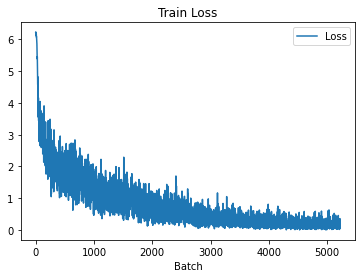

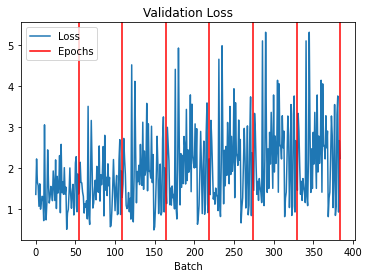

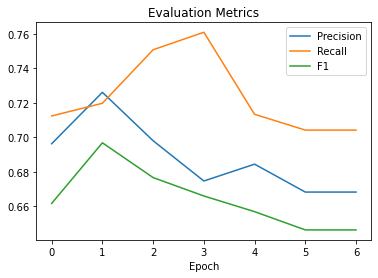

TEST LOSS:  2.309089363705028
PRECISION:  0.668208306317851
RECALL:  0.7041989599385066
F1-SCORE:  0.646230192419683



Example 1
Question: who is the owner of the mandalay bay in vegas ?
Prediction: mgm resorts international
Correct: mgm resorts international


Example 2
Question: what is the shannara chronicles season 2 based on ?
Prediction: the sword of shan ##nar ##a trilogy by terry brooks
Correct: the sword of shan ##nar ##a trilogy


Example 3
Question: who played taylor on the bold and beautiful ?
Prediction: hunter ty ##lo ( 1990 - - ) she ##rily ##n wo ##lter ( 1990 )
Correct: hunter ty ##lo ( 1990 - - ) she ##rily ##n wo ##lter ( 1990 )


Example 4
Question: what do you call initials that stand for something ?
Prediction: acronym
Correct: acronym


Example 5
Question: when did michigan last win a national championship ?
Prediction: 1989
Correct: 1989


Example 6
Question: when did holland become involved in world war 2 ?
Prediction: began with its invasion by nazi germany o

In [12]:
def main():
  '''Here's the basic structure of the main block -- feel free to add or
  remove parameters/helper functions as you see fit, but all steps here are 
  needed and we expect to see precision, recall, and f1 scores printed out'''

  # Setup device and hyperparameters
  if torch.cuda.is_available(): 
    print('Got GPU!')
    device = "cuda"  
  else: 
    print('Stuck w/ CPU :(')
    device = "cpu"
  NUM_EPOCHS = 6
  BATCH_SIZE = 16

  # Load model and data
  model, tokenizer = load_model()
  train, validation = load_data()

  # Data to dataloader
  train_dataloader = preprocess_and_tokenize(train, tokenizer, BATCH_SIZE)
  validation_dataloader = preprocess_and_tokenize(validation, tokenizer, BATCH_SIZE)

  # Make optimizer and lr_scheduler
  optimizer = make_optimizer(model)
  lr_scheduler = make_lr_scheduler(NUM_EPOCHS, train_dataloader, optimizer)

  # Train and evaluate model
  model.to(device)
  train_losses, val_losses, Ps, Rs, f1s = train_loop(model, optimizer, NUM_EPOCHS, train_dataloader, validation_dataloader, lr_scheduler, device)
  precision, recall, f1, test_loss  = eval_loop(model, validation_dataloader, device)
  
  # Compute results
  val_losses.append(test_loss)
  Ps.append(precision)
  Rs.append(recall)
  f1s.append(f1)
  av_test_loss = sum(test_loss)/len(test_loss)

  # Print Results
  visualize_train_loss(train_losses)
  visualize_val_loss(val_losses, NUM_EPOCHS)
  visualize_metrics(Ps, Rs, f1s)
  print("TEST LOSS: ", av_test_loss)
  print("PRECISION: ", precision)
  print("RECALL: ", recall)
  print("F1-SCORE: ", f1)
  visualize_model_performance(model, validation, validation_dataloader, tokenizer, device, BATCH_SIZE)


'''
Goal:
  Precision:  0.62
  Recall:  0.68
  F1:  0.59
'''


if __name__ == "__main__":
  main()